In [194]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error,r2_score
from tensorflow.keras.callbacks import TensorBoard

import pickle

# Random forest regression

In [3]:
df = pd.read_csv(os.getcwd()+"/pre_processing/dataset_traite_minute_mean_na.csv", sep=',', parse_dates=["DateTime"])

In [4]:
def data_to_supervised(df, col_to_predict="Global_active_power"):
    data = pd.DataFrame(df)
    n_vars = data.shape[1]
    columns = []
    columns.append(data.shift(1))
    columns.append(data.shift(0)[col_to_predict])
    df_labeled = pd.concat(columns, axis=1)
    names = [col + "(t-1)" for col in df.columns]
    names.append(f"{col_to_predict}(t)")
    df_labeled.columns = names
    df_labeled.dropna(inplace=True)
    
    return df_labeled

In [222]:
df_rf = df.set_index('DateTime')
df_rf = df_rf.resample('15min').mean()
delta_t_agregation = 60*15 #nbr de secondes par time step. ex: 60*60 pour un resample('h')
df_rf['Date'] = pd.to_datetime(df_rf.index.date)
df_rf

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Date
DateTime,,,,,,,,
2006-12-16 17:15:00,4.587333,0.484000,234.366667,19.700000,0.0,1.333333,16.833333,2006-12-16
2006-12-16 17:30:00,4.140667,0.327733,234.768667,17.773333,0.0,0.733333,16.866667,2006-12-16
2006-12-16 17:45:00,4.159333,0.028267,234.630000,17.786667,0.0,0.000000,16.866667,2006-12-16
2006-12-16 18:00:00,4.121067,0.152533,235.566000,17.706667,0.0,19.933333,17.000000,2006-12-16
2006-12-16 18:15:00,3.768533,0.017200,234.803333,16.226667,0.0,2.866667,16.933333,2006-12-16
...,...,...,...,...,...,...,...,...
2010-11-26 20:00:00,1.634533,0.058000,239.539333,6.933333,0.0,1.400000,0.000000,2010-11-26
2010-11-26 20:15:00,1.078933,0.117067,240.094667,4.560000,0.0,1.200000,0.000000,2010-11-26
2010-11-26 20:30:00,0.979200,0.047867,238.822667,4.120000,0.0,1.133333,0.000000,2010-11-26


In [223]:
temperatures = pd.read_csv("pre_processing/temperatures.csv", parse_dates=['Date'], index_col='Date')
temperatures['avg_t'] = (temperatures['max_t'] - temperatures['min_t'])/2
temperatures.head(2)

,min_t,max_t,avg_t
Date,,,
2006-01-02,3.0,7.6,2.30
2006-01-03,3.9,6.8,1.45


In [224]:
df_rf = df_rf.join(temperatures, how="left", on='Date')
df_rf = df_rf.drop(columns=['Date','avg_t'])
df_rf.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t
DateTime,,,,,,,,,
2006-12-16 17:15:00,4.587333,0.484000,234.366667,19.700000,0.0,1.333333,16.833333,0.3,9.5
2006-12-16 17:30:00,4.140667,0.327733,234.768667,17.773333,0.0,0.733333,16.866667,0.3,9.5
2006-12-16 17:45:00,4.159333,0.028267,234.630000,17.786667,0.0,0.000000,16.866667,0.3,9.5


In [22]:
#colonne unique int
# df_rf["Hour"] = df_rf.index.hour
# df_rf["Day"] = df_rf.index.dayofweek
# df_rf["Month"] = df_rf.index.month

#pour colonnes binaires :
# days=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
# for i in range(7):
#     df_rf[days[i]] = (df_rf.index.dayofweek == i).astype(int)

In [226]:
scaler = MinMaxScaler(feature_range=(-1,1))
df_rf[df_rf.columns] = scaler.fit_transform(df_rf[df_rf.columns])
df_rf.describe()

# df_rf["Hour"] = df_rf.index.hour
df_rf["Hour"] = df_rf.index.hour + df_rf.index.minute/60
df_rf["Day"] = df_rf.index.dayofweek
df_rf["Month"] = df_rf.index.month

# df_rf = data_to_supervised(df_rf)
df_rf.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t,Hour,Day,Month
DateTime,,,,,,,,,,,,
2006-12-16 17:15:00,0.062503,0.158264,-0.334486,0.063636,-1.0,-0.964570,0.208134,-0.415873,-0.321519,17.25,5,12
2006-12-16 17:30:00,-0.042742,-0.215699,-0.305125,-0.041455,-1.0,-0.980514,0.210526,-0.415873,-0.321519,17.50,5,12
2006-12-16 17:45:00,-0.038344,-0.932355,-0.315253,-0.040727,-1.0,-1.000000,0.210526,-0.415873,-0.321519,17.75,5,12


In [227]:
# dataset de validation qu'on garde dans l'ordre chronologique, pour tester une fois le modele entrainé avec le reste des données shuffled
df_val = df_rf.loc[df_rf.index >= "2010-11-15"]
df_val.shape[0]

df_rf = df_rf.loc[df_rf.index < "2010-11-15"]

In [196]:
def create_train_model(model_type, df_rf, y_col="Global_active_power", train_size = 0.8, shuffle=True, n_estimators=500, learning_rate=0.1):
    df_rf = data_to_supervised(df_rf, y_col)
    y_col = y_col + '(t)'
    X = df_rf.copy().drop(columns=[y_col])
    y = df_rf[y_col]

    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=train_size, shuffle=shuffle, random_state = 1)

    model = None
    if(model_type == "RandomForestRegressor"):
        model = RandomForestRegressor(n_estimators = n_estimators, random_state = 1)
    elif(model_type == "GradientBoostingRegressor"):
        model = GradientBoostingRegressor(n_estimators = n_estimators, learning_rate=learning_rate, random_state = 1)
    model.fit(train_X, train_y)

    ypred = model.predict(test_X)
    r2 = r2_score(test_y, ypred)
    r_adjusted = 1 - ( 1-r2 ) * ( len(test_y) - 1 ) / ( len(test_y) - test_X.shape[1] - 1 )
    mse = mean_squared_error(test_y, ypred)
    rmse = np.sqrt(mse)

    scores = {}
    scores['r2'] = r2
    scores['r_adjusted'] = r_adjusted
    scores['mse'] = mse
    scores['rmse'] = rmse

    return model, scores

In [190]:
#test of function above
# model, scores = create_train_model("RandomForestRegressor", df_rf, 'Global_active_power', train_size = 0.8, shuffle=True, n_estimators=700)
# print(f"R-squared: {scores['r2']}")
# print(f"Adjusted R-squared: {scores['r_adjusted']}")
# print(f"Test MSE: {scores['mse']}")
# print(f"Test RMSE: {scores['rmse']}")

R-squared: 0.7590572227202947
Adjusted R-squared: 0.7589605996597742
Test MSE: 0.013074216142134366
Test RMSE: 0.11434253863778943


In [201]:
#test of function above
# model, scores = create_train_model("GradientBoostingRegressor", df_rf, 'Global_active_power', train_size = 0.8, shuffle=True, n_estimators=500, learning_rate=0.10)
# print(f"R-squared: {scores['r2']}")
# print(f"Adjusted R-squared: {scores['r_adjusted']}")
# print(f"Test MSE: {scores['mse']}")
# print(f"Test RMSE: {scores['rmse']}")

R-squared: 0.7683359815866946
Adjusted R-squared: 0.7682430795012937
Test MSE: 0.012570725228981873
Test RMSE: 0.11211924557800892


In [202]:
#test of function above
# model, scores = create_train_model("GradientBoostingRegressor", df_rf, 'Global_active_power', train_size = 0.8, shuffle=True, n_estimators=500, learning_rate=0.12)
# print(f"R-squared: {scores['r2']}")
# print(f"Adjusted R-squared: {scores['r_adjusted']}")
# print(f"Test MSE: {scores['mse']}")
# print(f"Test RMSE: {scores['rmse']}")

R-squared: 0.7687583150269488
Adjusted R-squared: 0.7686655823060335
Test MSE: 0.012547808257806076
Test RMSE: 0.11201699986076254


In [228]:
# val_X = df_val.copy()#.drop(columns=["Global_active_power"])
# names = [col + "(t-1)" for col in val_X.columns]
# val_X.columns = names
# val_y = df_val["Global_active_power"]
# val_ypred = model.predict(val_X)
# val_ypred = np.insert(val_ypred, 0, np.nan)
# val_ypred


# nbr_steps = 300
# aa=[x for x in range(nbr_steps)]
# plt.figure(figsize=(40,10))
# plt.plot(aa, val_y[:nbr_steps], marker='.', label="actual")
# plt.plot(aa, val_ypred[:nbr_steps], 'r', label="prediction")
# plt.ylabel(df.columns[1], size=15)
# plt.xlabel('Time steps', size=15)
# plt.legend(fontsize=15)
# plt.show()

In [205]:
def create_models_all_var(model_type, df_rf, train_size=0.8, shuffle=True, n_estimators=500, learning_rate=0.1, verbose=False):
    non_predictable_vars = ["min_t", "max_t", "avg_t", "Hour", "Day", "Month"]
    models = {}
    models_scores = {}
    for col in df_rf.columns:
        if(col not in non_predictable_vars):
            if(verbose):
                print(f"Training a model on predicting the {col} variable")
            model, scores = create_train_model(model_type, df_rf, col, train_size, shuffle, n_estimators, learning_rate)
            models[col] = model
            models_scores[col] = scores

    return models, models_scores

In [247]:
model_type = ["RandomForestRegressor", "GradientBoostingRegressor"]
models, models_scores = create_models_all_var(model_type[1], df_rf, train_size=0.8, shuffle=True, n_estimators=500, learning_rate=0.12, verbose=True)

Training a model on predicting the Global_active_power variable
Training a model on predicting the Global_reactive_power variable
Training a model on predicting the Voltage variable
Training a model on predicting the Global_intensity variable
Training a model on predicting the Sub_metering_1 variable
Training a model on predicting the Sub_metering_2 variable
Training a model on predicting the Sub_metering_3 variable


In [248]:
#scores of models trained above
for col in models_scores.keys():
    print(f"\nScores for the model trained to predict {col}:")
    print(f"R-squared: {models_scores[col]['r2']}")
    print(f"Adjusted R-squared: {models_scores[col]['r_adjusted']}")
    print(f"Test MSE: {models_scores[col]['mse']}")
    print(f"Test RMSE: {models_scores[col]['rmse']}")


Scores for the model trained to predict Global_active_power:
R-squared: 0.7684867105663914
Adjusted R-squared: 0.7684613981936229
Test MSE: 0.012530466169555207
Test RMSE: 0.11193956480867347

Scores for the model trained to predict Global_reactive_power:
R-squared: 0.3426137887180163
Adjusted R-squared: 0.34254191377349996
Test MSE: 0.03193603074122227
Test RMSE: 0.17870654923987053

Scores for the model trained to predict Voltage:
R-squared: 0.8790344773066527
Adjusted R-squared: 0.8790212516105813
Test MSE: 0.006272847900349394
Test RMSE: 0.07920131249133056

Scores for the model trained to predict Global_intensity:
R-squared: 0.7630626481228708
Adjusted R-squared: 0.7630367427133449
Test MSE: 0.012095301651675326
Test RMSE: 0.10997864179773874

Scores for the model trained to predict Sub_metering_1:
R-squared: 0.4458196521051051
Adjusted R-squared: 0.44575906111449204
Test MSE: 0.01001141519530851
Test RMSE: 0.10005705969749716

Scores for the model trained to predict Sub_metering

In [232]:
def predict_all_variables(models, x_row, temperatures, timesteps_forward=1, delta_t_agregation=60*60):
    date = datetime.datetime.fromisoformat(str(x_row.index[0]))

    rows = x_row.copy()
    names = [col + "(t-1)" for col in rows.columns]
    rows.columns = names
    for i in range(timesteps_forward):
        date = date + datetime.timedelta(seconds=delta_t_agregation)
        prediction = []
        for model_name in models.keys():
            last_line = pd.DataFrame(rows.iloc[rows.shape[0]-1]).transpose()
            prediction.append(models[model_name].predict(last_line)[0])
        prediction.append(temperatures.loc[str(date)]["min_t"])
        prediction.append(temperatures.loc[str(date)]["max_t"])
        prediction.append(date.hour + date.minute/60)
        prediction.append(date.weekday())
        prediction.append(date.month)

        prediction = pd.Series(prediction, index = names)
        rows = rows.append(prediction, ignore_index=True)

    rows = rows.drop(index=0)#drop thefirst initial row, used to start the predictions
    return rows

In [249]:
indice_inicial_row = 100
nbr_pred = 4*24 #24*5
initial_row = pd.DataFrame(df_val.iloc[indice_inicial_row]).transpose()
# initial_row = pd.DataFrame(df_rf.loc["2009-05-17 13:00:00"]).transpose()
initial_row

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t,Hour,Day,Month
2010-11-16 01:00:00,-0.962583,-0.894384,0.254875,-0.954909,-1.0,-1.0,-1.0,0.015873,-0.240506,1.0,1.0,11.0


In [250]:
temps = df_val[["min_t", "max_t"]]
predictions = predict_all_variables(models, initial_row, temps, nbr_pred, delta_t_agregation)
predictions.head()

,Global_active_power(t-1),Global_reactive_power(t-1),Voltage(t-1),Global_intensity(t-1),Sub_metering_1(t-1),Sub_metering_2(t-1),Sub_metering_3(t-1),min_t(t-1),max_t(t-1),Hour(t-1),Day(t-1),Month(t-1)
1,-0.951146,-0.810065,0.244643,-0.943569,-1.000119,-0.998986,-0.994064,0.015873,-0.240506,1.25,1.0,11.0
2,-0.945656,-0.832879,0.231145,-0.926155,-0.999932,-0.999022,-0.790849,0.015873,-0.240506,1.50,1.0,11.0
3,-0.949388,-0.834329,0.224637,-0.941039,-0.999932,-0.999022,-0.759824,0.015873,-0.240506,1.75,1.0,11.0
4,-0.961610,-0.830177,0.258728,-0.952324,-0.999932,-0.999022,-0.801223,0.015873,-0.240506,2.00,1.0,11.0
5,-0.962077,-0.817636,0.279103,-0.956057,-0.999932,-0.998986,-0.787317,0.015873,-0.240506,2.25,1.0,11.0


In [251]:
inv_y = df_val.iloc[indice_inicial_row:indice_inicial_row+nbr_pred+1]["Global_active_power"]
inv_yhat = predictions["Global_active_power(t-1)"]
inv_yhat = pd.concat([pd.Series([np.nan]), inv_yhat])
# inv_y = df_val["Sub_metering_1"]
# inv_yhat = predictions["Sub_metering_1(t-1)"]

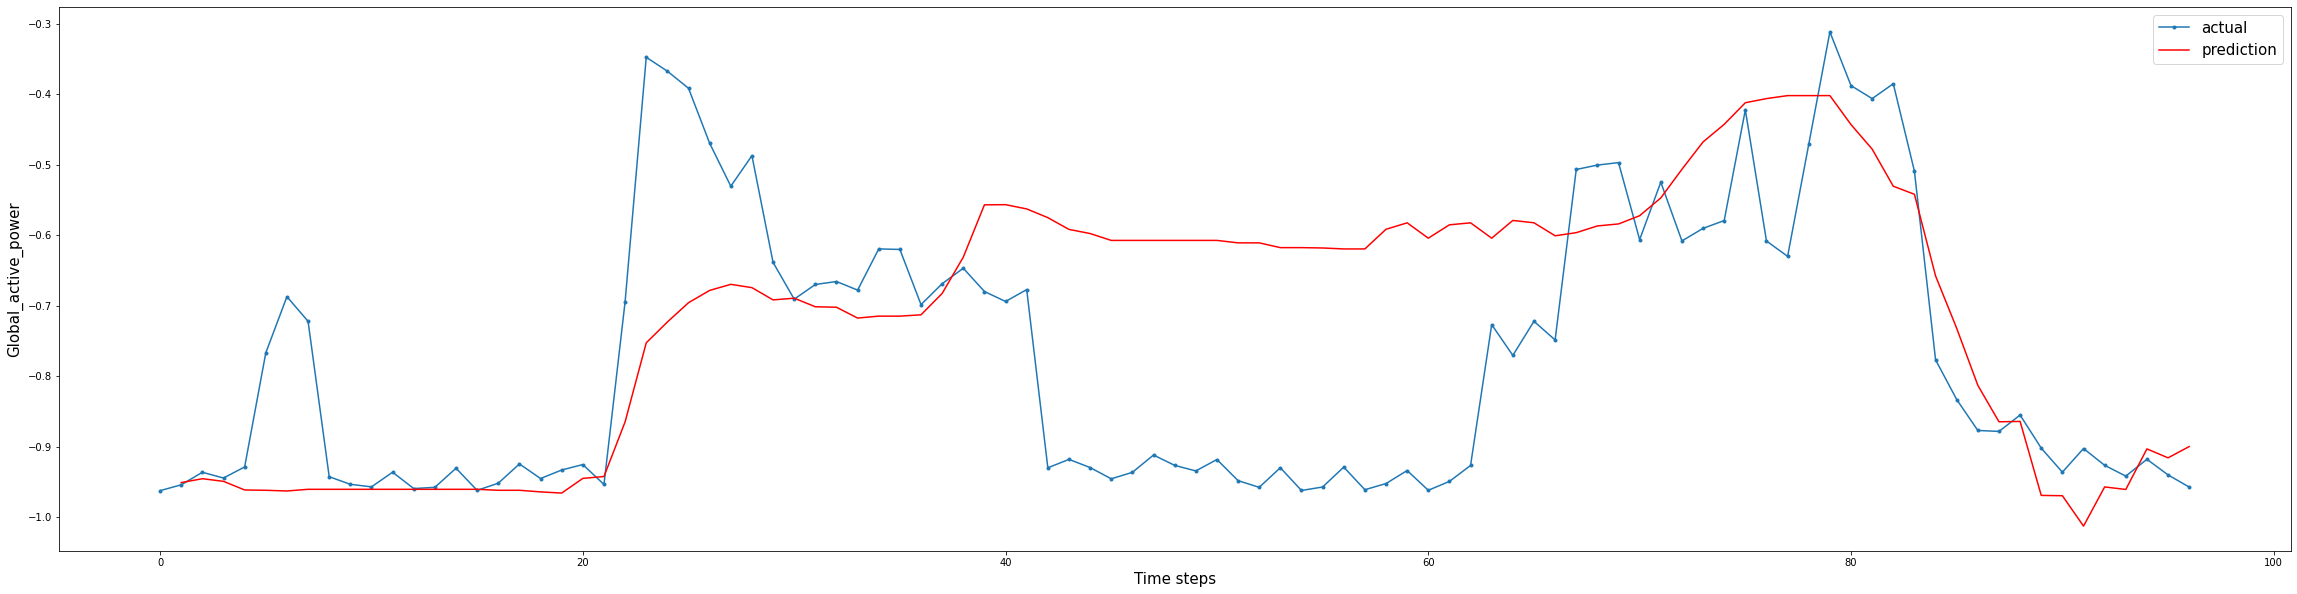

In [252]:
nbr_steps = len(inv_yhat)
aa=[x for x in range(nbr_steps)]
plt.figure(figsize=(40,10))
plt.plot(aa, inv_y[:nbr_steps], marker='.', label="actual")
plt.plot(aa, inv_yhat[:nbr_steps], 'r', label="prediction")
plt.ylabel(df.columns[1], size=15)
plt.xlabel(f'Time steps', size=15)
plt.legend(fontsize=15)
plt.show()

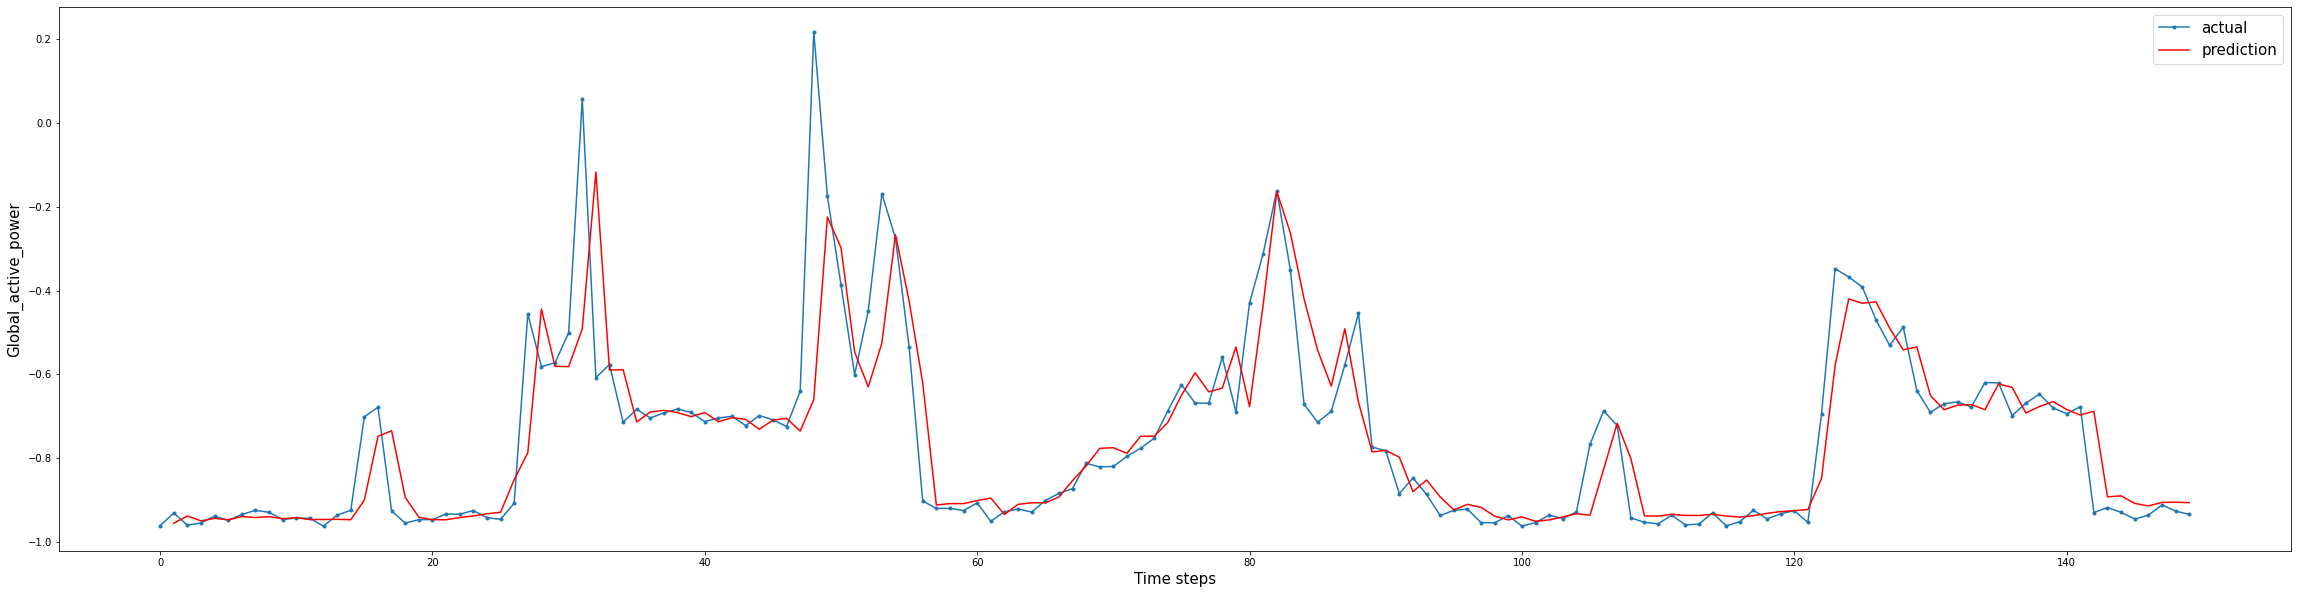

In [253]:
val_X = df_val.copy()#.drop(columns=["Global_active_power"])
names = [col + "(t-1)" for col in val_X.columns]
val_X.columns = names
val_y = df_val["Global_active_power"]
val_ypred = models["Global_active_power"].predict(val_X)
val_ypred = np.insert(val_ypred, 0, np.nan)
val_ypred


nbr_steps = 150
aa=[x for x in range(nbr_steps)]
plt.figure(figsize=(40,10))
plt.plot(aa, val_y[:nbr_steps], marker='.', label="actual")
plt.plot(aa, val_ypred[:nbr_steps], 'r', label="prediction")
plt.ylabel(df.columns[1], size=15)
plt.xlabel('Time steps', size=15)
plt.legend(fontsize=15)
plt.show()

In [21]:
#serialize models
for model in models.keys():
    filename =f"models/{model}.sav"
    pickle.dump(model, open(filename, 'wb'))
    print(f"{model} predicting model saved on disk as {filename}")

Global_active_power predicting model saved on disk as models/Global_active_power.sav
Global_reactive_power predicting model saved on disk as models/Global_reactive_power.sav
Voltage predicting model saved on disk as models/Voltage.sav
Global_intensity predicting model saved on disk as models/Global_intensity.sav
Sub_metering_1 predicting model saved on disk as models/Sub_metering_1.sav
Sub_metering_2 predicting model saved on disk as models/Sub_metering_2.sav
Sub_metering_3 predicting model saved on disk as models/Sub_metering_3.sav


In [ ]:
# X = df_rf.copy().drop(columns=['Global_active_power(t)'])
# y = df_rf["Global_active_power(t)"]

In [ ]:
# dataset de validation qu'on garde dans l'ordre chronologique, pour tester une fois le modele entrainé avec le reste des données shuffled
# val_X = X.loc[X.index > "2010-11-15"]
# val_y = y.loc[y.index > "2010-11-15"]
# val_X.shape[0]

# X = X.loc[X.index <= "2010-11-15"]
# y = y.loc[y.index <= "2010-11-15"]

In [ ]:
# train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, shuffle=True)

In [ ]:
# rf_reg = RandomForestRegressor(n_estimators = 500, random_state = 1)
# rf_reg.fit(train_X, train_y)

In [ ]:
# ypred = rf_reg.predict(test_X)

# r2 = r2_score(test_y, ypred)
# print("R-squared:", r2)
# r_adjusted = 1 - ( 1-r2 ) * ( len(test_y) - 1 ) / ( len(test_y) - test_X.shape[1] - 1 )
# print("Adjusted R-squared:", r_adjusted)

# mse = mean_squared_error(test_y, ypred)
# print(f'Test MSE: {mse}')
# rmse = np.sqrt(mse)
# print(f'Test RMSE: {rmse}')

In [ ]:
# size = df_rf.shape[1]-1
# test_X["ypred"] = ypred
# test_X
# ypred = ypred.reshape(-1,1)
# ypred = scaler.inverse_transform(test_X)["ypred"]
# # test_y = scaler.inverse_transform(test_y)

# inv_yhat = np.concatenate((ypred, test_X[:, 1-size:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]

# test_y = test_y.reshape((len(test_y), 1))
# inv_y = np.concatenate((test_y, test_X[:, 1-size:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]

# descaler = MinMaxScaler()
# descaler.min_,descaler.scale_=scaler.min_[0],scaler.scale_[0]
# ypred = descaler.inverse_transform(ypred)

In [ ]:
val_ypred = rf_reg.predict(val_X)

In [ ]:
nbr_steps = 100
aa=[x for x in range(nbr_steps)]
plt.figure(figsize=(40,10))
plt.plot(aa, val_y[:nbr_steps], marker='.', label="actual")
plt.plot(aa, val_ypred[:nbr_steps], 'r', label="prediction")
plt.ylabel(df.columns[1], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
values = df_rf.values

trainsize = 0.8
n_rows = round(len(values)*trainsize)
print(f"Taille du trainset : {n_rows}")

train = values[:n_rows, :]
test = values[n_rows:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D format as expected by LSTMs [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model = Sequential()
#recurrent_activation ='selu' # 1er place
#recurrent_activation ='softsign' # 2e place

model.add(LSTM(5*24, input_shape=(train_X.shape[1], train_X.shape[2]),recurrent_activation ='sigmoid',activation='tanh',return_sequences=True))
model.add(LSTM(5*24,recurrent_activation ='sigmoid',activation='tanh',return_sequences=False))
#model.add(LSTM(2*24,recurrent_activation ='sigmoid',activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')
#model.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.001),
             # loss=tensorflow.keras.losses.MeanSquaredError(),
             # metrics=['mse'])
model.summary()

In [ ]:
# fit network
history = model.fit(train_X, train_y, epochs=4, batch_size=100, validation_data=(test_X, test_y), verbose=1, shuffle=False)

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
size = df_rf.shape[1]-1
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], size))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
test_y

In [ ]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

import sklearn
r2 = sklearn.metrics.r2_score(inv_y, inv_yhat)
print(r2)
r_adjusted = 1 - ( 1-r2 ) * ( len(test_y) - 1 ) / ( len(test_y) - test_X.shape[1] - 1 )
print(r_adjusted)

In [ ]:
nbr_steps = 50
aa=[x for x in range(nbr_steps)]
plt.figure(figsize=(40,10))
plt.plot(aa, inv_y[:nbr_steps], marker='.', label="actual")
plt.plot(aa, inv_yhat[:nbr_steps], 'r', label="prediction")
plt.ylabel(df.columns[1], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()